Changes between v2 and v2.1: Instead of multiplying Obs0 and Obs1 with eV, multiply f0 and f1 with eV to avoid problems due to calculating with small numbers

Changes to v2.1: Includes plots of force and potential as function of interactomic distance, and 2 Options for calculating the force. Removed the factor angst of dR, since coordinates are passed to the get_qubit_op function in units of angst, but dR was previously in units of m. The sign of the force is wrong, which is why we changed it in the dynamics function. It would be best to just use one coordinate instead of two to circumvent this issue

Changes to v2.2: Fixed some reproducibility issues

Note: should agree on sensible units, because doing calculations in SI units results in problems
The force function seems to be more physical now (correct stationary point), but is one order of magnitude smaller than the values in the paper, and the sign is the wrong way around for some reason, which is why we changed it in the dynamics function.



In [1]:
from qiskit.algorithms import VQE
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
import matplotlib.pyplot as plt
import numpy as np
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.quantum_info.operators import Operator



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def calc_energy(op,num_part,num_orb,problem,converter):
    
    backend = BasicAer.get_backend("statevector_simulator")

    #no clue why this is needed. Without it the initial state has different # of qubits than the number of qubits in qubit operator
    # and we get an error. 
    result = exact_solver(problem,converter)

    optimizer = SLSQP(maxiter=5)

        #result = exact_solver(problem,converter)
        #exact_energies.append(result.total_energies[0].real)
    
    init_state = HartreeFock(num_orb, num_part, converter)
   
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    
    vqe_calc = vqe.compute_minimum_eigenvalue(op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    return vqe_result  

In [2]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction



def get_qubit_op(coordinates):

    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0], 0.0, 0.0] ],
            ["H", [coordinates[1], 0.0, 0.0] ]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter):

    backend = BasicAer.get_backend("statevector_simulator")
 
    result = exact_solver(problem,converter)

    optimizer = SLSQP(maxiter=5)

    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=backend) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    #vqe_ground = vqe_result.eigenstate perhaps more accurate? Downside: don't get circuit 
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    return vqe_ground, min_eng

In [3]:
eV = 1.602e-19
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst

def calc_forces(coordinates):
    
    #get qubit operator corresponding to H(R)
    (qubit_op, _, _, problem, converter) = get_qubit_op([coordinates[0],coordinates[1]])

    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus_0, _, _, problem_plus_0, converter_plus_0) = get_qubit_op([coordinates[0] + dR,coordinates[1]])
    
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus_0, num_part, num_orb, problem_minus_0, converter_minus_0) = get_qubit_op([coordinates[0] - dR,coordinates[1]])
 
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)
    
    #define desired observable (H_+ - H_-)/(2dR) = force  
    Obs0 = (qubit_op_plus_0-qubit_op_minus_0)
       
    #get the expectation value <psi_0|O|psi_0>¨
    
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=8024)

    
    psi_0 = CircuitStateFn(psi_0)
    '''
    # Option 1: Calucate the force according to Equation 7
    measurable_expression = StateFn(Obs0, is_measurement=True).compose(psi_0) 
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    f0 = sampler.eval().real
    '''
    
    #Option 2: Calculate the force according to Equation 6
    
    f0_plus = calc_energy(qubit_op_plus_0,num_part,num_orb,problem_plus_0,converter_plus_0)
    f0_minus = calc_energy(qubit_op_minus_0,num_part,num_orb,problem_minus_0,converter_minus_0)
    f0 = f0_plus - f0_minus
    
    
    ### repeat same for other atom ###
    (qubit_op_plus_1, _, _, _, _) = get_qubit_op([coordinates[0],coordinates[1]+dR])
    
    (qubit_op_minus_1, num_particles, num_spin_orbitals, problem, converter) = get_qubit_op([coordinates[0],coordinates[1]-dR])

    #define desired observable (H_+ - H_-)/(2dR) = force  
    Obs1 = (qubit_op_plus_1-qubit_op_minus_1)
    
    backend = Aer.get_backend('qasm_simulator') 
    q_instance = QuantumInstance(backend, shots=1)
    measurable_expression = StateFn(Obs1, is_measurement=True).compose(psi_0) 
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    f1 = sampler.eval().real
    
    return f0*eV*(1/(2*dR*angst)),f1*eV*(1/(2*dR*angst))

In [7]:
#implementation of the simple Verlet integrator
femto = 1.0e-15
angst = 1.0e-10


#mass of particle1 (H)
mass_0 = 1.67e-27
#mass of particle2 (H)
mass_1 = 1.67e-27
#time step of integrator
dt = 0.2*femto
#initial velocity of atoms
v_init_0 = 0
v_init_1 = 0

#initial positions of atoms
init_pos = [0,1]

#integrator timesteps
times = np.arange(0*femto, 20.0*femto, dt)
#coordinate array
coords = [init_pos]
force = []

for time in times:
    r = coords[-1]
    (f0,f1) = calc_forces(coords[-1])
    force.append(f0)
    if time == 0:
        r0_next = r[0]*angst + v_init_0*dt - 0.5*f0/mass_0*(dt*dt)
        r1_next = r[1]*angst + v_init_1*dt - 0.5*f1/mass_1*(dt*dt)
        coords.append([r0_next/angst,r1_next/angst])
    else:
        r_prev = coords[-2]
        r0_next = 2*r[0]*angst - r_prev[0]*angst - f0/mass_0*(dt*dt)
        r1_next = 2*r[1]*angst - r_prev[1]*angst - f1/mass_1*(dt*dt)
        coords.append([r0_next/angst,r1_next/angst])

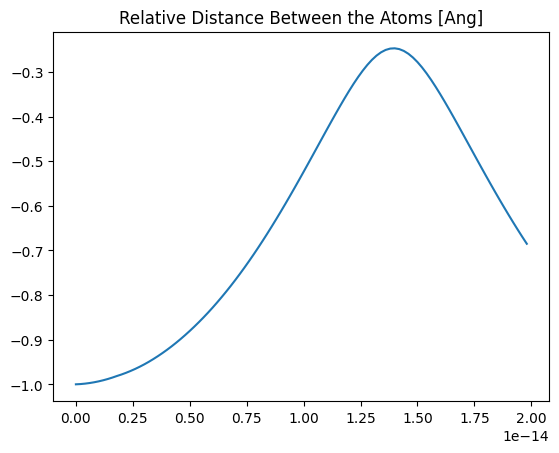

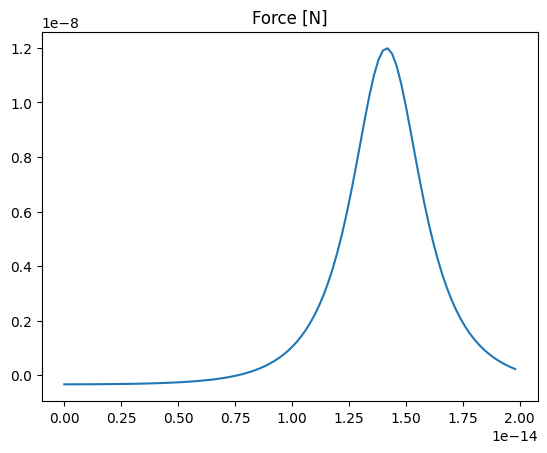

In [8]:
#plot relative distance of molecules as function of time

coords_np = np.array(coords)
rel_dist = coords_np[1:,0] - coords_np[1:,1]
plt.plot(times,rel_dist)
plt.title('Relative Distance Between the Atoms [Ang]')
plt.show()
plt.plot(times,force)
plt.title('Force [N]')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


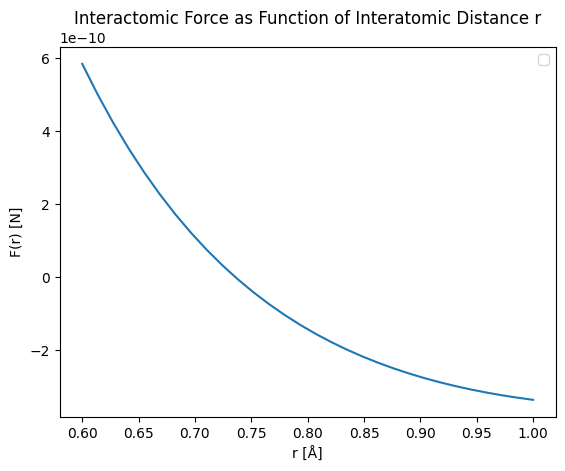

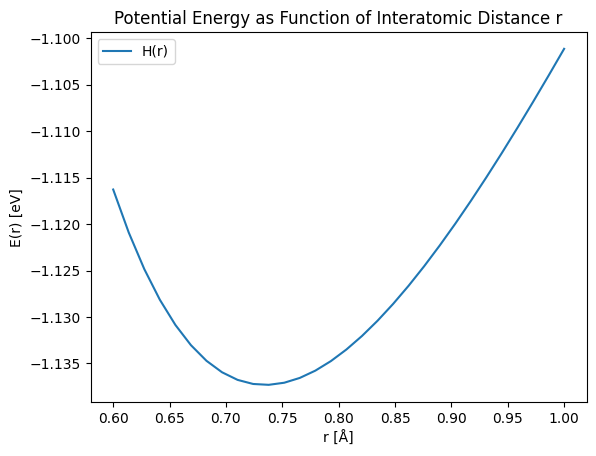

In [9]:
n = 30 # number of points
r = np.linspace(0.6,1.0,n)
forces = np.zeros(n)
potential = np.zeros(n)

for x in range(n):
    dist = r[x]
    forces[x],_= calc_forces([0,dist])
    op, num_part, num_orb, problem, converter = get_qubit_op([0,dist])
    potential[x] = calc_energy(op,num_part,num_orb,problem,converter)
    
plt.plot(r,forces)
plt.title('Interactomic Force as Function of Interatomic Distance r')
plt.xlabel('r [Å]')
plt.ylabel('F(r) [N]')
plt.legend()
plt.show()

plt.plot(r,potential, label = 'H(r)')

plt.title('Potential Energy as Function of Interatomic Distance r')
plt.xlabel('r [Å]')
plt.ylabel('E(r) [eV]')
plt.legend()
plt.show()

    